# Labeling Online Comments into the degrees of Toxicity!

<p class="lead">This time we have decided to learn to label the <a href="https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge">Dataset</a> of online comments into different level of toxicity,</p>

Online comments present some gruesome verbal abuses to its mostly innocent users , if we could label each comments in their degrees of 'toxicity' we could enforce it in any platform that can ensure its user with no verbal abuses.
This could be deployed in any social media if we could label with utmost accuracy!


In [4]:
import pandas as pd
import numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

from scipy.sparse import csr_matrix, hstack

import pickle
import random

import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import string

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

In [5]:
comments=pd.read_csv("train.csv")
# test=pd.read_csv("test.csv")
comments.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

<p class="lead">There were 159571 rows of labeled data of online comments </p>


In [5]:
comments.head(6)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0


In [6]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

<p class="lead">Above six are the labels present in data
    where , 143346 out of 159571 comments were free of any toxicity</p>


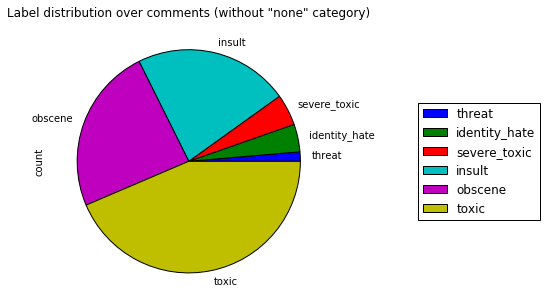

In [4]:
comments['none'] = (comments[cols_target].max(axis=1) == 0).astype(int)
cols_target.append('none')
df_distribution = comments[cols_target].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.drop('none').plot.pie(y='count',
                                      title='Label distribution over comments (without "none" category)',
                                      figsize=(5, 5))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

<p class="lead">Above chart shows the distribution of each label in the dataset</p>
<p class="lead">Where,</p>
<p class="lead">Toxic comments were significantly high</p>
<p class="lead">insults and obscene comments were next most common occuring</p>

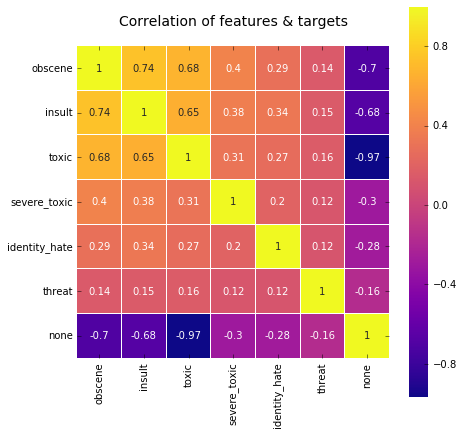

In [5]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(comments[cols_target].astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

<p class="lead">As the data is multi-labeled, which means the labels are not mutually exclusive to each other and one data can be classified into many labels so, we needed to see quick overview of the  <b>correlation </b> between the labels.</p>

<p class="lead"> It was found that some labels correlated with each other:-</p>
    <p class="lead" >'toxic' <=> 'none' -0.97</p>
<p class="lead"> toxic <=>'insult' 0.65 </p>
    <p class="lead"> toxic <=>'obscene' 0.68 </p>
    
    

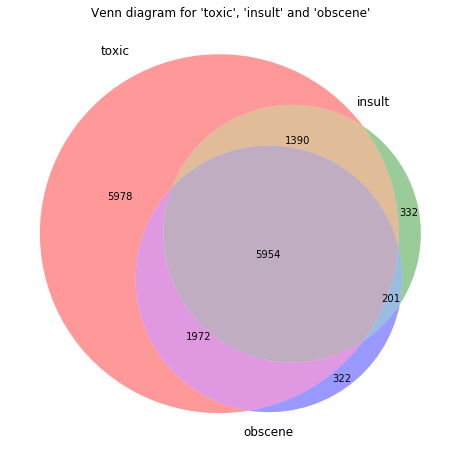

In [6]:
t = comments[(comments['toxic'] == 1) & (comments['insult'] == 0) & (comments['obscene'] == 0)].shape[0]
i = comments[(comments['toxic'] == 0) & (comments['insult'] == 1) & (comments['obscene'] == 0)].shape[0]
o = comments[(comments['toxic'] == 0) & (comments['insult'] == 0) & (comments['obscene'] == 1)].shape[0]

t_i = comments[(comments['toxic'] == 1) & (comments['insult'] == 1) & (comments['obscene'] == 0)].shape[0]
t_o = comments[(comments['toxic'] == 1) & (comments['insult'] == 0) & (comments['obscene'] == 1)].shape[0]
i_o = comments[(comments['toxic'] == 0) & (comments['insult'] == 1) & (comments['obscene'] == 1)].shape[0]

t_i_o = comments[(comments['toxic'] == 1) & (comments['insult'] == 1) & (comments['obscene'] == 1)].shape[0]

plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'insult' and 'obscene'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o), 
      set_labels=('toxic', 'insult', 'obscene'))
plt.show()

<p class="lead"> The Above Venn Diagram sorts out the mutually existing label features among most correlated three labels</p>
    <p class="lead"> 5954 of the cases or comments fell into all three labels 'obscene' ,'toxic' and 'insult</p>
       
    

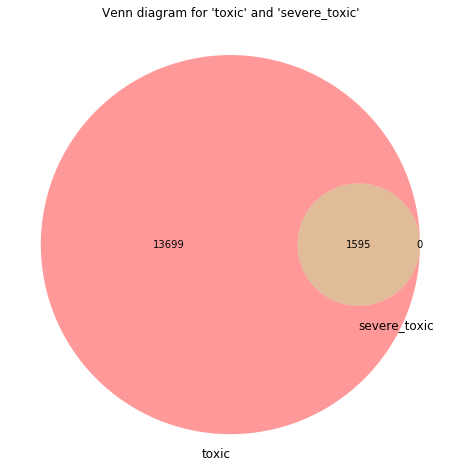

In [7]:
t = comments[(comments['toxic'] == 1) & (comments['severe_toxic'] == 0)].shape[0]
s = comments[(comments['toxic'] == 0) & (comments['severe_toxic'] == 1)].shape[0]

t_s = comments[(comments['toxic'] == 1) & (comments['severe_toxic'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic' and 'severe_toxic'")
venn2(subsets = (t, s, t_s), 
      set_labels=('toxic', 'severe_toxic'))
plt.show()

<p class="lead"> All the 'severe toxic' comments fell into 'toxic'category as it is the technically also true</p>
    

In [7]:
train_t,test_t, train_class,test_class = train_test_split(comments['comment_text'],comments[cols_target],test_size=0.3)

# Learning To Label The Data

### This is a classic Multi-Label classification problem where there are multiple labels to learn and predict.We can approach it in two ways:-
#### 1. Problem Transformation ( where we transform the problem into  into binary classification problems or  into multi-class classification problem)

#### 2. Adapted algorithms (boosting and ML-KNN can be used to classify multi-labeled 


<p class='lead' > Binary Relevance </p>

Binary Relevance treats the problem as one vs all problem

In [9]:
pipeline = Pipeline([
    ('tfidf',TfidfVectorizer(max_features=5000,stop_words='english',ngram_range=(1,3))),
    ('classifier',LogisticRegression(C=12.0))
])
pipe_logreg_model=[]
for label in cols_target:
    print(label)
    y = train_class[label]
    pipeline.fit(train_t, y)
    pickle.dump(pipeline, open(label+'.sav', 'wb'))
    y_pred = pipeline.predict(test_t)
    y_test=test_class[label]
    print('Test accuracy is {}'.format(accuracy_score(y_test, y_pred)))


obscene
Test accuracy is 0.9780247326203209
insult
Test accuracy is 0.9695020053475936
toxic
Test accuracy is 0.9535636697860963
severe_toxic
Test accuracy is 0.9902865975935828
identity_hate
Test accuracy is 0.9919577205882353
threat
Test accuracy is 0.9973262032085561


In [10]:
model=[pickle.load(open(i+'.sav','rb')) for i in cols_target ]


In [23]:
cols_targets=cols_target[:]
predic=([i.predict([''])[0] for i in model])
[n for i,n in enumerate(cols_targets) if predic[i]==1]


[]

### In this model , First we transformed the original comments into tf-idf vector and then feed the data as binary class classification problem into the model of Logistic regression through a pipeline,The results are posted above for each label 


# Multi-outputEnsemble

In [29]:
# from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import ClassifierChain

classifier = ClassifierChain(RandomForestClassifier(n_estimators=100))
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect_train_t = vect.fit_transform(train_t)
vect_test_t=vect.fit_transform(test_t)


In [257]:
vet=vect.fit(['hello there how are you sitting there okay okay get get'])

In [259]:
print(vet.transform(['hello there how are you sitting there okay okay get get']))

  (0, 2)	0.4082482904638631
  (0, 1)	0.8164965809277261
  (0, 0)	0.4082482904638631


In [32]:
classifier.fit(vect_train_t,train_class)


y_pred = classifier.predict(vect_test_t)
y_test=test_class
print('Test accuracy is {}'.format(accuracy_score(y_test, y_pred)))

Test accuracy is 0.8489722593582888


## In this Model we have used RandomForestClassifier with Classifier chain to get multi-output this is the example of  Adaptive algorithm to solve multi label classifier.


<p class='lead' > The accuracy was found to be 84%</p>

In [8]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

for category in cols_target:
    print('... Processing {}'.format(category))
    NB_pipeline.fit(train_t, train_class[category])

    prediction = NB_pipeline.predict(test_t)
    print('Test accuracy is {}'.format(accuracy_score(test_class[category], prediction)))

... Processing obscene
Test accuracy is 0.9540858957219251
... Processing insult
Test accuracy is 0.953542780748663
... Processing toxic
Test accuracy is 0.9212274398395722
... Processing severe_toxic
Test accuracy is 0.9902865975935828
... Processing identity_hate
Test accuracy is 0.9911430481283422
... Processing threat
Test accuracy is 0.997033756684492


<p class='lead' > This model uses another one vs rest Classifier which uses MultinomialNB classifier and produces the similar results </p>

# Summary

- Approaching text labeling with degrees of toxicity
- toxic,insult and obscene were closely related and mostly overlapped
- Two methods were explored:-
    -Problem Transformation
    -Adapter Algorithms
- Problem Transformations were implemented
- Binary Relevance was implemented using Logistic Regression
- Multi-Output classifier was trained using randomforestclassifier and found with 84% of accuracy
-  MultinominalNB was used as OneVsRestclassifier and met with good accuracies for each labels